In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import CubicHermiteSpline
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from financepy.utils import *
from financepy.products.rates import *
from tqdm import tqdm
import datetime
import pickle

####################################################################
#  FINANCEPY BETA Version 0.370 - This build: 28 Oct 2024 at 20:26 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



读取处理过的数据，保留数据齐全的数据，调整时间格式

In [37]:
df = pd.read_excel('MicroRV_CW.xlsx')
df.dropna(inplace=True) # dates where all benchmark instruments are available
# convert date to format dd-mm-yyyy
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df.set_index('Date', inplace=True)
# convert to float
df = df.astype(np.float32)

In [38]:
df

,BPSWS1Z Curncy,BPSWS2Z Curncy,BPSWSA Curncy,BPSWSB Curncy,BPSWSE Curncy,BPSWSF Curncy,BPSWSG Curncy,BPSWSH Curncy,BPSWSI Curncy,BPSWSJ Curncy,...,BPSWS8 Curncy,BPSWS9 Curncy,BPSWS10 Curncy,BPSWS12 Curncy,BPSWS15 Curncy,BPSWS20 Curncy,BPSWS25 Curncy,BPSWS30 Curncy,BPSWS40 Curncy,BPSWS50 Curncy
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-27,0.19560,0.38050,0.38050,0.43390,0.61670,0.67380,0.74200,0.79440,0.84270,0.89160,...,1.18400,1.17000,1.15820,1.1314,1.11480,1.06650,1.02200,0.98120,0.89275,0.80450
2022-01-28,0.22930,0.38450,0.38450,0.43750,0.63216,0.69100,0.75890,0.81300,0.86277,0.91184,...,1.20635,1.19205,1.18135,1.1593,1.13870,1.09380,1.05250,1.01580,0.92410,0.83600
2022-01-31,0.33260,0.41175,0.41175,0.47100,0.66400,0.72300,0.79670,0.85310,0.90340,0.95515,...,1.25550,1.23790,1.22800,1.2130,1.18600,1.14400,1.10225,1.06700,0.98105,0.89615
2022-02-01,0.36900,0.42165,0.42165,0.47700,0.66610,0.72550,0.79400,0.85360,0.89930,0.94730,...,1.24800,1.23400,1.22400,1.2038,1.17790,1.13300,1.09200,1.05600,0.96620,0.88300
2022-02-02,0.40855,0.43415,0.43415,0.49000,0.67320,0.72580,0.79080,0.84631,0.89184,0.93803,...,1.22300,1.20800,1.19700,1.1750,1.14700,1.09600,1.05100,1.01100,0.92025,0.83355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-19,4.70180,4.70390,4.71000,4.70410,4.62260,4.59625,4.56487,4.53630,4.51151,4.48554,...,3.97335,3.97900,3.99100,4.0265,4.07392,4.10692,4.09602,4.05797,3.98100,3.86650
2024-11-20,4.70200,4.70390,4.71000,4.70400,4.61850,4.58900,4.55400,4.52600,4.49900,4.47290,...,3.94650,3.95450,3.96800,4.0060,4.05550,4.09050,4.08150,4.04400,3.96646,3.85300
2024-11-21,4.70200,4.70400,4.71000,4.69700,4.59500,4.56280,4.52550,4.49250,4.46300,4.43410,...,3.89800,3.90600,3.91850,3.9560,4.00500,4.03900,4.03096,3.99400,3.94695,3.83185


In [39]:
columns = ['1W','2W']
for i in [1,2,5,6,7,8,9,10,11]:
    columns.append(str(i)+'M')
columns.append('1Y')
columns.append('18M')
for i in [2,3,4,5,6,7,8,9,10,12,15,20,25,30,40,50]:
    columns.append(str(i)+'Y')

for old_name, new_name in zip(df.columns, columns):
    df.rename(columns={old_name: new_name}, inplace=True)

将各期限转为年为单位，并构建dictionary

In [40]:
# convert tenors to numpy array in the unit of year
tenors = np.array([1/52, 2/52, 1/12, 2/12, 5/12, 6/12, 7/12, 8/12, 9/12, 10/12, 11/12, 1, 1.5, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 40, 50])
# a dictionary that match column names to tenors
tenors_dict = dict(zip(df.columns, tenors))
# fit a hermite spline to first row with selected tenors
selected_tenors = df.columns # select some tenors not all to show that the curve is interpolated
x = np.array([tenors_dict[i] for i in selected_tenors])
date = df.index[0]
y = df.loc[date, selected_tenors].values

In [41]:
x

array([1.92307692e-02, 3.84615385e-02, 8.33333333e-02, 1.66666667e-01,
       4.16666667e-01, 5.00000000e-01, 5.83333333e-01, 6.66666667e-01,
       7.50000000e-01, 8.33333333e-01, 9.16666667e-01, 1.00000000e+00,
       1.50000000e+00, 2.00000000e+00, 3.00000000e+00, 4.00000000e+00,
       5.00000000e+00, 6.00000000e+00, 7.00000000e+00, 8.00000000e+00,
       9.00000000e+00, 1.00000000e+01, 1.20000000e+01, 1.50000000e+01,
       2.00000000e+01, 2.50000000e+01, 3.00000000e+01, 4.00000000e+01,
       5.00000000e+01])

In [42]:
y

array([0.1956 , 0.3805 , 0.3805 , 0.4339 , 0.6167 , 0.6738 , 0.742  ,
       0.7944 , 0.8427 , 0.8916 , 0.933  , 0.9691 , 1.1354 , 1.235  ,
       1.294  , 1.28285, 1.26005, 1.2267 , 1.2035 , 1.184  , 1.17   ,
       1.1582 , 1.1314 , 1.1148 , 1.0665 , 1.022  , 0.9812 , 0.89275,
       0.8045 ], dtype=float32)

Text(0, 0.5, 'Rate (%)')

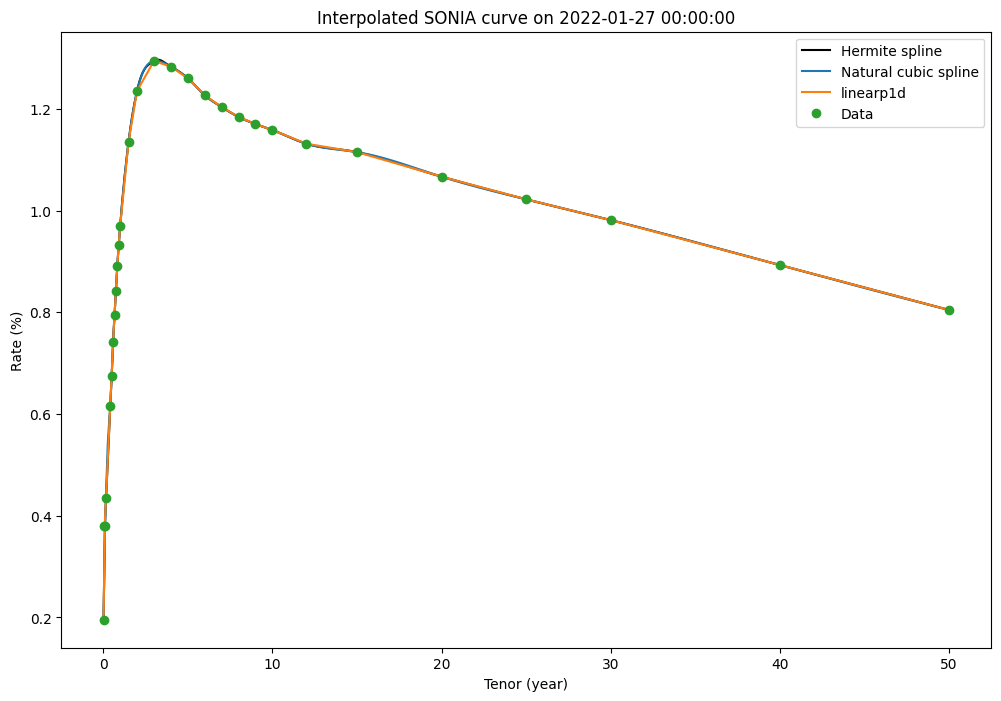

In [43]:
# cubic hermite spline
cs = CubicHermiteSpline(x, y, np.gradient(y, x), axis=0)
# natural cubic spline
cs_natrual = CubicSpline(x, y)
# linear
cs_linear = interp1d(x, y)

# interpolate
xnew = np.arange(1/52,50,1/12) # every month
ynew = cs(xnew)
ynew_natrual = cs_natrual(xnew)
ynew_linear = cs_linear(xnew)
#plot natrual cubic spline
plt.figure(figsize=(12,8))
plt.plot(xnew, ynew, '-', label='Hermite spline',color='black')
plt.plot(xnew, ynew_natrual, '-', label='Natural cubic spline')
plt.plot(xnew, ynew_linear, '-', label='linearp1d')

plt.plot(x,y,'o', label='Data')
plt.xlabel('Tenor (year)')
plt.legend()
plt.title(f'Interpolated SONIA curve on {date}')
plt.ylabel('Rate (%)')

In [44]:
def plotCurve(curve, start_date, tmax, instr_mat_dates_or_tenor = None, title = ''):
    """
    Plots zero rates, ON fwd rates and term fwd rates for a curve
    Inputs:
    curve: IborSingleCurve
    start_date: Date
    tmax: float, max time in years
    instr_mat_dates_or_tenor: None or list of Dates or a tenor string
    title: str, title of the plot
    """
    years = np.linspace(1/365, tmax, int(365*tmax)//30) # split the time into 30 day intervals
    dates = start_date.add_years(years) # the array of end dates for the curve
    zero_rates = curve.zero_rate(dates) # zero_rate
    on_fwd_rates = curve.fwd(dates) # ON fwd rates

    ys_monthly = np.arange(1,tmax*12+1)/12
    monthly_dates = start_date.add_years(ys_monthly)

    if instr_mat_dates_or_tenor is not None:
        # Will plot term forward rates
        # instr_mat_dates_or_tenor could be a list of curve-building
        # isntrument maturities in which case term fwd rates go from the last instrument maturiy date that is less
        # than the plotting date to the plotting date. Or it could be a tenor so that fwd rates cover that tenor 
        # i.e. the term fwd rate for d covers [max(d-tenor,start_date), d]
        # tenor should be a positive tenor

        if isinstance(instr_mat_dates_or_tenor, str):
            neg_tenor = '-' + instr_mat_dates_or_tenor
            start_fwd_dates = [d.add_tenor(neg_tenor) for d in dates]
            start_fwd_dates = [d if d > start_date else start_date for d in start_fwd_dates]
            fwd_rate_label = f'term fwd rates for [d-{instr_mat_dates_or_tenor},d]'
        else:
            instr_mat_dates_or_tenor = [start_date] + instr_mat_dates_or_tenor
            start_fwd_dates = [ max([md  for md in instr_mat_dates_or_tenor if md < d]) for d in dates]
            fwd_rate_label = 'term fwd rates from prev instr mtrty'

        term_fwd_rates = curve.fwd_rate(start_fwd_dates, dates)

    plt.figure(figsize=(8,6))
    plt.plot(years, zero_rates*100, '-', label="zero rates")
    plt.plot(years, on_fwd_rates*100, '-', label = "ON fwd rates")

    if instr_mat_dates_or_tenor is not None:
        plt.plot(years, term_fwd_rates*100, '.', label = fwd_rate_label)

    plt.xlabel("Times in years")
    plt.ylabel("Rates (%) - See Legend")
    plt.title(title)
    plt.legend()

In [45]:
# Demonstrate fitting a curve using the first date
valuation_date = Date(df.index[0].day, df.index[0].month, df.index[0].year)
spot_days = 0 # T+0 as shown in Bloomberg ticker
settlement_date = valuation_date.add_weekdays(spot_days)
cal = CalendarTypes.UNITED_KINGDOM
# store SONIA swap as we only have swap as benchmark instruments
swaps = []
swapType = SwapTypes.PAY # pay fixed
fixedDCCType = DayCountTypes.ACT_365F # 365 fixed
fixedFreqType = FrequencyTypes.ANNUAL # annual
floatFreqType = FrequencyTypes.ANNUAL # annual
floatDCCType = DayCountTypes.ACT_365F # 365 fixed

for tenor in df.columns:
   if tenor[-1]=='Y': # only append yearly tenors for swap
      rate = df.loc[df.index[0], tenor]/100 # convert to %
      swap = IborSwap(effective_dt=settlement_date, term_dt_or_tenor=tenor,
                      fixed_leg_type=swapType, fixed_cpn=float(rate), fixed_freq_type=fixedFreqType, fixed_dc_type=fixedDCCType,
                      float_freq_type=floatFreqType, float_dc_type=floatDCCType, cal_type=cal)
      swaps.append(swap)

Text(0.5, 1.0, 'Interpolated SONIA curve on 27-01-2022')

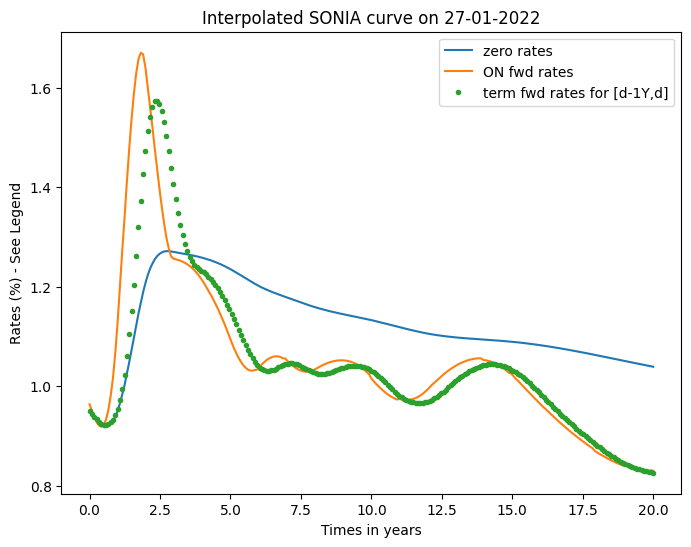

In [46]:
curve = IborSingleCurve(valuation_date, ibor_deposits = [], ibor_fras = [] , ibor_swaps = swaps, interp_type = InterpTypes.NATCUBIC_ZERO_RATES) 
plotCurve(curve, valuation_date, 20, instr_mat_dates_or_tenor='1Y')
plt.title(f'Interpolated SONIA curve on {df.index[0].strftime("%d-%m-%Y")}')

In [47]:
# create a yield curve dataset with columns in years, and rows same as df.index
# create a curves dictionary to store the calibrated curve for each date
curves = {}
year_columns = list(df.columns[df.columns.str.endswith('Y')]) # list of yearly tenors
year_columns = [int(i[:-1]) for i in year_columns] # convert to int
df_yield = pd.DataFrame(index=df.index, columns=year_columns) # 1y to 25y
# swap characteristics
swapType = SwapTypes.PAY # pay fixed
fixedDCCType = DayCountTypes.ACT_365F # 365 fixed
fixedFreqType = FrequencyTypes.ANNUAL # annual
floatFreqType = FrequencyTypes.ANNUAL # annual
floatDCCType = DayCountTypes.ACT_365F # 365 fixed

for date in tqdm(df.index, desc='Creating curves'): # loop through each date in the dataset
    swaps = []
    day, month, year = date.day, date.month, date.year
    valuation_date = Date(day, month, year) # convet to Date object
    spot_days = 0 # T+0
    settlement_date = valuation_date.add_weekdays(spot_days)
    for tenor in df.columns: # loop through each tenor in the dataset
        if tenor[-1]=='Y':
            rate = df.loc[date, tenor]/100
            swap = IborSwap(effective_dt=settlement_date, term_dt_or_tenor=tenor,
                            fixed_leg_type=swapType, fixed_cpn=float(rate), fixed_freq_type=fixedFreqType, fixed_dc_type=fixedDCCType,
                            float_freq_type=floatFreqType, float_dc_type=floatDCCType, cal_type=cal)
            swaps.append(swap)

    curve = IborSingleCurve(valuation_date, ibor_deposits = [], ibor_fras = [] , ibor_swaps = swaps, interp_type = InterpTypes.NATCUBIC_ZERO_RATES)
    for year in year_columns:
        df_yield.loc[date, year] = curve.swap_rate(effective_dt=valuation_date,maturity_dt=valuation_date.add_years(year))
    curves[date] = curve # add this curve to the dictionary

Creating curves: 100%|██████████| 716/716 [10:00<00:00,  1.19it/s]


### butterfly

In [3]:
with open('curves.pkl', 'rb') as f:
    curves = pickle.load(f)  
df_yield = pd.read_pickle('df_yield.pkl')

In [4]:
# z = 2 * rb - ra - rc
def compute_fly_from_curves(curves, fly_legs, window=60, rate_type='zero',K=15):
    """
    根据已拟合好的 financepy curves，计算给定 butterfly 结构的 fly spread 和 z-score。

    参数:
    - curves: dict[Date] → IborSingleCurve
    - fly_legs: list of (a,b,c) tuples，代表不同的 fly 结构（单位：年）
    - window: 滚动窗口长度（单位：天数）
    - rate_type: 'zero' 或 'forward'，表示从 curve 中提取哪种利率计算 fly

    返回:
    - fly_df: 每天每个结构的 fly spread
    - zscore_df: 每天每个结构的 z-score
    """

    fly_data = {f"{a}-{b}-{c}": [] for (a, b, c) in fly_legs}
    zscore_data = {f"{a}-{b}-{c}": [] for (a, b, c) in fly_legs}
    dates = list(curves.keys())[0:20*K]
    dates.sort()

    for idx in range(window, len(dates)):
        current_date = dates[idx]
        current_curve = curves[current_date]

        past_fly_dict = {f"{a}-{b}-{c}": [] for (a, b, c) in fly_legs}

        # 过去窗口内的 fly spread 序列
        for hist_date in dates[idx - window: idx]:
            hist_curve = curves[hist_date]
            for (a, b, c) in fly_legs:
                d_a = Date(hist_date.day, hist_date.month, hist_date.year).add_years(a)
                d_b = Date(hist_date.day, hist_date.month, hist_date.year).add_years(b)
                d_c = Date(hist_date.day, hist_date.month, hist_date.year).add_years(c)

                if rate_type == 'zero':
                    try:
                        ra = hist_curve.zero_rate(d_a)
                        rb = hist_curve.zero_rate(d_b)
                        rc = hist_curve.zero_rate(d_c)
                    except:
                        continue
                elif rate_type == 'forward':
                    try:
                        ra = hist_curve.fwd(d_a)
                        rb = hist_curve.fwd(d_b)
                        rc = hist_curve.fwd(d_c)
                    except:
                        continue
                else:
                    raise ValueError("rate_type must be 'zero' or 'forward'")

                fly_hist = 2 * rb - ra - rc
                past_fly_dict[f"{a}-{b}-{c}"].append(fly_hist)

        # 当前日期的 fly 和 z-score
        for (a, b, c) in fly_legs:
            d_a = Date(current_date.day, current_date.month, current_date.year).add_years(a)
            d_b = Date(current_date.day, current_date.month, current_date.year).add_years(b)
            d_c = Date(current_date.day, current_date.month, current_date.year).add_years(c)

            try:
                if rate_type == 'zero':
                    ra = current_curve.zero_rate(d_a)
                    rb = current_curve.zero_rate(d_b)
                    rc = current_curve.zero_rate(d_c)
                else:
                    ra = current_curve.fwd(d_a)
                    rb = current_curve.fwd(d_b)
                    rc = current_curve.fwd(d_c)

                fly_today = 2 * rb - ra - rc
                fly_data[f"{a}-{b}-{c}"].append(fly_today)

                hist_vals = past_fly_dict[f"{a}-{b}-{c}"]
                if len(hist_vals) >= 5:
                    mu = np.mean(hist_vals)
                    sigma = np.std(hist_vals)
                    z = (fly_today - mu) / sigma if sigma > 1e-6 else 0
                else:
                    z = np.nan
                zscore_data[f"{a}-{b}-{c}"].append(z)
            except:
                fly_data[f"{a}-{b}-{c}"].append(np.nan)
                zscore_data[f"{a}-{b}-{c}"].append(np.nan)

    fly_df = pd.DataFrame(fly_data, index=dates[window:])
    zscore_df = pd.DataFrame(zscore_data, index=dates[window:])
    return fly_df, zscore_df

In [5]:
fly_legs = [(2, 5, 10), (5, 10, 30), (3, 5, 7)]
rollingwindow = 60  #day, 相当于3个月
fly_df_forward, z_df_forward = compute_fly_from_curves(curves, fly_legs, window=rollingwindow, rate_type='forward',K=15) 

In [6]:
def select_best_trades(criteria_computed,N=10):
    z_flat = criteria_computed.stack().dropna()  # 把 z_df 转成长表
    return z_flat[z_flat.abs().sort_values(ascending=False).head(N).index] # 按照绝对值排序

best_10_trades = select_best_trades(z_df_forward,100)
best_10_trades

2022-09-27  5-10-30   -6.113262
2022-06-22  5-10-30    6.087881
2022-09-28  3-5-7     -5.918000
2022-04-22  2-5-10    -5.372883
2022-09-29  5-10-30    5.107139
                         ...   
2023-02-07  2-5-10     1.668075
2022-05-20  2-5-10     1.597223
2022-05-06  2-5-10    -1.545579
2022-05-18  3-5-7     -1.520498
2022-05-12  5-10-30   -1.506404
Length: 100, dtype: float64

In [7]:
def simulate_fly_pnl_dv01(start_date, structure, curves, notional=1e6):
    """
    基于 swap DV01 模拟 fly spread 的 PnL
    
    参数:
    - start_date: 信号触发日期（开仓）
    - structure: tuple (a,b,c)，表示 fly: 2b - a - c
    - curves: dict[pd.Timestamp] → IborSingleCurve
    - notional: 每条leg的名义本金，默认 100 万
    
    返回:
    - pnl_series: 每天的 fly 结构的累计 PnL
    - leg_pnls: 每条leg的单独 PnL 路径
    """
    a, b, c = structure
    all_dates = sorted([d for d in curves if d >= start_date])
    if len(all_dates) == 0:
        return None, None

    # 起始日期 & 每条leg的 maturity
    d0 = start_date
    d0_date = Date(d0.day, d0.month, d0.year)
    mty_a = d0_date.add_years(a)
    mty_b = d0_date.add_years(b)
    mty_c = d0_date.add_years(c)

    curve_0 = curves[d0]
    
    def swap_dv01(curve, start_date, maturity_date):
        """根据贴现现金流估算 swap DV01"""
        try:
            tau = 1  # annual accrual
            d = start_date.add_years(1)
            payment_dates = []
            while d <= maturity_date:
                payment_dates.append(d)
                d = d.add_years(1)
            discount_factors = [curve.df(p) for p in payment_dates]
            return sum(tau * df for df in discount_factors)
        except:
            return np.nan

    # 开仓时每条leg的 swap rate 和 DV01
    legs = {
        'a': {'mty': mty_a, 'sign': -1},
        'b1': {'mty': mty_b, 'sign': 2},
        'c': {'mty': mty_c, 'sign': -1},
    }

    for key, leg in legs.items():
        leg['rate_open'] = curve_0.swap_rate(d0_date, leg['mty'])
        leg['dv01'] = swap_dv01(curve_0, d0_date, leg['mty'])

    legs['a']['notional'] = notional
    legs['c']['notional'] = notional
    legs['b1']['notional'] = (notional * legs['a']['dv01'] + notional * legs['c']['dv01']) / (2 * legs['b1']['dv01'])
    #print(legs['b1']['notional'])

    # 模拟持仓期间的每日 PnL
    pnl_data = {k: [] for k in legs}
    total_pnl = []

    for d in all_dates:
        curve = curves[d]
        d_date = Date(d.day, d.month, d.year)
        daily_pnl = 0
        for key, leg in legs.items():
            try:
                rate_now = curve.swap_rate(d_date, leg['mty']) #maturity在变，attention！
                rate_diff = rate_now - leg['rate_open']
                leg_pnl = float(rate_diff * leg['dv01'] * leg['notional'] * leg['sign'])
                pnl_data[key].append(leg_pnl)
                daily_pnl += leg_pnl
            except:
                pnl_data[key].append(np.nan)
                daily_pnl = np.nan
        total_pnl.append(daily_pnl)

    pnl_series = pd.Series(total_pnl, index=all_dates)
    leg_pnls = pd.DataFrame(pnl_data, index=all_dates)
    return pnl_series, leg_pnls

In [8]:
def backtest_top_n_fly_trades_dv01(top_signals, curves, notional=1e6):
    """
    使用 DV01 精确计算每个交易的 PnL

    参数：
    - top_signals: 选出来的top trades
    - curves: dict[pd.Timestamp] → IborSingleCurve
    - notional: 每条leg的名义本金

    返回：
    - result_df: 每笔交易的明细
    - summary: 总结
    """
    records = []

    for (date, structure_str) in top_signals.index:
        z_score = top_signals.loc[date, structure_str]
        structure = tuple(map(int, structure_str.split('-')))
        direction = -1 if z_score > 0 else 1  # 正z做空fly，负z做多fly

        try:
            pnl_series, leg_pnls = simulate_fly_pnl_dv01(date, structure, curves, notional=notional)
            if pnl_series is None or pnl_series.dropna().empty:
                continue

            adjusted_pnl = direction * pnl_series
            final_pnl = adjusted_pnl.dropna().iloc[-1] #到期or最后一天pnl
            max_drawdown = (adjusted_pnl.cummax() - adjusted_pnl).max()

            records.append({
                'start_date': date,
                'structure': structure_str,
                'z_score': z_score,
                'direction': 'short fly' if z_score > 0 else 'long fly',
                'final_pnl': final_pnl,
                'max_drawdown': max_drawdown,
                'duration': len(adjusted_pnl)
            })
        except Exception as e:
            continue

    result_df = pd.DataFrame(records)
    
    summary = {
        'Total Trades': len(result_df),
        'Win Ratio': (result_df['final_pnl'] > 0).mean(),
        'Average PnL': result_df['final_pnl'].mean(),
        'Average Max Drawdown': result_df['max_drawdown'].mean(),
        'Average Duration': result_df['duration'].mean()
    }
    
    return result_df, summary

In [9]:
result, summary = backtest_top_n_fly_trades_dv01(best_10_trades, curves, notional=1e6)

/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_41664/791361536.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  leg_pnl = float(rate_diff * leg['dv01'] * leg['notional'] * leg['sign'])


In [11]:
result

,start_date,structure,z_score,direction,final_pnl,max_drawdown,duration
0,2022-09-27,5-10-30,-6.113262,long fly,-59544.193377,177350.360202,550
1,2022-06-22,5-10-30,6.087881,short fly,76672.425901,157598.812652,616
2,2022-09-28,3-5-7,-5.918000,long fly,-29813.623031,45546.025043,549
3,2022-04-22,2-5-10,-5.372883,long fly,31492.037804,88274.128884,656
4,2022-09-29,5-10-30,5.107139,short fly,78533.775414,63867.684353,548
...,...,...,...,...,...,...,...
95,2023-02-07,2-5-10,1.668075,short fly,2516.477117,44222.363721,457
96,2022-05-20,2-5-10,1.597223,short fly,-7845.843021,111776.391505,637
97,2022-05-06,2-5-10,-1.545579,long fly,27727.717623,92268.140550,647
98,2022-05-18,3-5-7,-1.520498,long fly,-1061.583196,50868.524294,639


In [12]:
summary #duration感觉应该也没啥用？

{'Total Trades': 100,
 'Win Ratio': np.float64(0.66),
 'Average PnL': np.float64(14412.774761839286),
 'Average Max Drawdown': np.float64(98786.17659690518),
 'Average Duration': np.float64(598.09)}

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
plt.style.use('ggplot')

# Assume we have the data frames from the previous code
# fly_df_forward: DataFrame of butterfly spreads
# z_df_forward: DataFrame of z-scores
# best_10_trades: Series of the top 10 trades by absolute z-score
# result: DataFrame with backtest results for top trades

# 1. Z-Score Evolution Over Time
def plot_zscore_evolution(z_df, top_trades=None, title="Z-Score Evolution Over Time"):
    """Plot z-scores over time with highlights for top trades"""
    plt.figure(figsize=(12, 8))
    
    # Plot all z-scores as light lines
    for col in z_df.columns:
        plt.plot(z_df.index, z_df[col], alpha=0.3, linewidth=1, color='gray')
    
    # Highlight top trades if provided
    if top_trades is not None:
        # Create a set of (date, structure) for quick lookup
        top_trades_set = set(top_trades.index)
        
        # Plot the specific structures that contain top trades with thicker lines
        for col in z_df.columns:
            if any((date, col) in top_trades_set for date in z_df.index):
                plt.plot(z_df.index, z_df[col], linewidth=2, label=col)
                
                # Mark the exact top trade points
                for date, structure in top_trades_set:
                    if structure == col:
                        plt.scatter(date, top_trades[(date, structure)], 
                                    s=100, color='red', zorder=5,
                                    edgecolor='black')
                        
    plt.axhline(y=2, color='red', linestyle='--', alpha=0.7, label='Z = +2')
    plt.axhline(y=-2, color='red', linestyle='--', alpha=0.7, label='Z = -2')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    plt.title(title, fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Z-Score', fontsize=14)
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

# 2. Butterfly Spread Evolution
def plot_fly_evolution(fly_df, title="Butterfly Spread Evolution"):
    """Plot butterfly spreads over time"""
    plt.figure(figsize=(12, 6))
    
    for col in fly_df.columns:
        plt.plot(fly_df.index, fly_df[col] * 10000, label=col)  # Convert to basis points
    
    plt.title(title, fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Spread (bps)', fontsize=14)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

# 3. PnL Evolution for Top Trades
def plot_pnl_evolution(result, curves, best_trades, notional=1e6):
    """Plot PnL evolution for top trades"""
    plt.figure(figsize=(14, 8))
    
    # Choose a color palette
    colors = plt.cm.tab10(np.linspace(0, 1, len(best_trades)))
    
    for i, ((start_date, structure_str), z_score) in enumerate(best_trades.items()):
        structure = tuple(map(int, structure_str.split('-')))
        direction = -1 if z_score > 0 else 1  # Reverse for short/long
        
        # Simulate PnL
        pnl_series, _ = simulate_fly_pnl_dv01(start_date, structure, curves, notional)
        if pnl_series is not None and not pnl_series.empty:
            adjusted_pnl = direction * pnl_series.cumsum()
            plt.plot(adjusted_pnl.index, adjusted_pnl.values, 
                     #label=f"{structure_str} ({start_date.strftime('%Y-%m-%d')})",
                     color=colors[i], linewidth=2)
    
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.title('PnL Evolution for Top Trades', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Cumulative PnL ($)', fontsize=14)
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt.gcf()

# 4. Trade Performance Summary
def plot_trade_performance(result):
    """Visualize the performance metrics of the trades"""
    if len(result) == 0:
        return None
    
    fig = plt.figure(figsize=(15, 12))
    gs = gridspec.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1.5])
    
    # 1. PnL Distribution
    ax1 = fig.add_subplot(gs[0, 0])
    sns.histplot(result['final_pnl'], bins=10, kde=True, ax=ax1)
    ax1.axvline(x=0, color='red', linestyle='--')
    ax1.set_title('Distribution of Final PnL', fontsize=14)
    ax1.set_xlabel('PnL ($)', fontsize=12)
    
    # 2. PnL by Structure
    ax2 = fig.add_subplot(gs[0, 1])
    structures = result['structure'].unique()
    avg_pnl_by_structure = result.groupby('structure')['final_pnl'].mean().sort_values()
    sns.barplot(x=avg_pnl_by_structure.index, y=avg_pnl_by_structure.values, ax=ax2)
    ax2.set_title('Average PnL by Structure', fontsize=14)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    ax2.set_ylabel('Average PnL ($)', fontsize=12)
    
    # 3. PnL vs Z-Score
    ax3 = fig.add_subplot(gs[1, 0])
    sns.scatterplot(x='z_score', y='final_pnl', data=result, s=70, ax=ax3)
    ax3.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax3.set_title('Final PnL vs Z-Score', fontsize=14)
    ax3.set_xlabel('Z-Score at Entry', fontsize=12)
    ax3.set_ylabel('Final PnL ($)', fontsize=12)
    
    # 4. PnL vs Duration
    ax4 = fig.add_subplot(gs[1, 1])
    sns.scatterplot(x='duration', y='final_pnl', data=result, s=70, ax=ax4)
    ax4.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax4.set_title('Final PnL vs Trade Duration', fontsize=14)
    ax4.set_xlabel('Duration (days)', fontsize=12)
    ax4.set_ylabel('Final PnL ($)', fontsize=12)
    
    # 5. Trade Summary Table
    ax5 = fig.add_subplot(gs[2, :])
    ax5.axis('tight')
    ax5.axis('off')
    
    # Create a performance summary
    win_rate = (result['final_pnl'] > 0).mean() * 100
    avg_win = result[result['final_pnl'] > 0]['final_pnl'].mean() if any(result['final_pnl'] > 0) else 0
    avg_loss = result[result['final_pnl'] < 0]['final_pnl'].mean() if any(result['final_pnl'] < 0) else 0
    profit_factor = abs(result[result['final_pnl'] > 0]['final_pnl'].sum() / 
                        result[result['final_pnl'] < 0]['final_pnl'].sum()) if result[result['final_pnl'] < 0]['final_pnl'].sum() != 0 else float('inf')
    
    summary_data = [
        ["Number of Trades", len(result)],
        ["Win Rate", f"{win_rate:.2f}%"],
        ["Average PnL", f"${result['final_pnl'].mean():.2f}"],
        ["Average Win", f"${avg_win:.2f}"],
        ["Average Loss", f"${avg_loss:.2f}"],
        ["Profit Factor", f"{profit_factor:.2f}"],
        ["Max PnL", f"${result['final_pnl'].max():.2f}"],
        ["Min PnL", f"${result['final_pnl'].min():.2f}"],
        ["Average Max Drawdown", f"${result['max_drawdown'].mean():.2f}"],
        ["Average Duration", f"{result['duration'].mean():.1f} days"]
    ]
    
    table = ax5.table(cellText=summary_data, colLabels=["Metric", "Value"], 
                      cellLoc='center', loc='center', cellColours=[['#f2f2f2']*2]*len(summary_data))
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)
    
    plt.suptitle("Trade Performance Summary", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return fig
    


plot_zscore_evolution(z_df_forward, best_10_trades)
plot_fly_evolution(fly_df_forward)
plot_pnl_evolution(result, curves, best_10_trades, notional=1e6)#
plot_trade_performance(result)

# Function to generate a summary report
def generate_strategy_report(result, summary):
    """Generate a text summary of the trading strategy results"""
    if len(result) == 0:
        return "No valid trades were found in the analysis."
    
    # Calculate additional metrics
    winning_trades = result[result['final_pnl'] > 0]
    losing_trades = result[result['final_pnl'] < 0]
    
    win_count = len(winning_trades)
    loss_count = len(losing_trades)
    
    avg_win_amount = winning_trades['final_pnl'].mean() if win_count > 0 else 0
    avg_loss_amount = losing_trades['final_pnl'].mean() if loss_count > 0 else 0
    
    total_pnl = result['final_pnl'].sum()
    avg_pnl = result['final_pnl'].mean()
    
    # Format the report
    report = f"""
    Micro RV Trading Strategy Performance Report
    ============================================
    
    Overview:
    ---------
    Total Trades: {len(result)}
    Winning Trades: {win_count} ({win_count/len(result)*100:.1f}%)
    Losing Trades: {loss_count} ({loss_count/len(result)*100:.1f}%)
    
    Performance:
    ------------
    Total PnL: ${total_pnl:.2f}
    Average PnL per Trade: ${avg_pnl:.2f}
    Average Winning Trade: ${avg_win_amount:.2f}
    Average Losing Trade: ${avg_loss_amount:.2f}
    Profit Factor: {abs(winning_trades['final_pnl'].sum() / losing_trades['final_pnl'].sum()):.2f} if loss_count > 0 else "∞"
    
    Risk Metrics:
    ------------
    Average Maximum Drawdown: ${result['max_drawdown'].mean():.2f}
    Largest Drawdown: ${result['max_drawdown'].max():.2f}
    Average Trade Duration: {result['duration'].mean():.1f} days
    
    Structure Analysis:
    -----------------
    Best Performing Structure: {result.groupby('structure')['final_pnl'].mean().idxmax()} (Avg PnL: ${result.groupby('structure')['final_pnl'].mean().max():.2f})
    Worst Performing Structure: {result.groupby('structure')['final_pnl'].mean().idxmin()} (Avg PnL: ${result.groupby('structure')['final_pnl'].mean().min():.2f})
    
    Z-Score Analysis:
    ---------------
    Average Entry Z-Score (absolute): {result['z_score'].abs().mean():.2f}
    Best Z-Score Range: {result.groupby(pd.cut(result['z_score'].abs(), bins=3))['final_pnl'].mean().idxmax()}
    
    Conclusion:
    ----------
    The strategy {("was profitable" if total_pnl > 0 else "was not profitable")}, generating a total PnL of ${total_pnl:.2f} 
    across {len(result)} trades. The win rate was {win_count/len(result)*100:.1f}% with an average profit per trade of ${avg_pnl:.2f}.
    """
    
    return report

/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_41664/791361536.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  leg_pnl = float(rate_diff * leg['dv01'] * leg['notional'] * leg['sign'])
